In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

In [7]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [16]:
adata.X = adata.layers["counts"].copy()

In [19]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'METABOLISM_OF_AMINO_ACIDS_AND_',
            'FACTORS_INVOLVED_IN_MEGAKARYOC', 'ADAPTIVE_IMMUNE_SYSTEM']

In [20]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [21]:
for i in ix_f:
    del adata.uns['terms'][i]

In [22]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [23]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

### Create TRVAE model and train it on reference dataset

In [24]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1952 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 277
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  277 0 0 4 1952
	with hard mask.


In [25]:
ALPHA = 0.7

In [26]:
OMEGA = None

In [27]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Init proximal operator for main terms.
 |█████████-----------| 47.8%  - epoch_loss:  864.28 - epoch_recon_loss:  839.71 - epoch_kl_loss:   49.13 - val_loss:  931.09 - val_recon_loss:  905.98 - val_kl_loss:   50.23
ADJUSTED LR
 |██████████----------| 51.5%  - epoch_loss:  867.06 - epoch_recon_loss:  842.31 - epoch_kl_loss:   49.50 - val_loss:  925.80 - val_recon_loss:  900.52 - val_kl_loss:   50.58
ADJUSTED LR
 |██████████----------| 54.8%  - epoch_loss:  868.71 - epoch_recon_loss:  843.98 - epoch_kl_loss:   49.45 - val_loss:  923.78 - val_recon_loss:  898.59 - val_kl_loss:   50.38
ADJUSTED LR
 |███████████---------| 58.0%  - epoch_loss:  864.71 - epoch_recon_loss:  840.03 - epoch_kl_loss:   49.36 - val_loss:  926.52 - val_recon_loss:  901.25 - val_kl_loss:   50.55
ADJUSTED LR
 |████████████--------| 60.8%  - epoch_loss:  865.39 - epoch_recon_loss:  840.74 - epoch_kl_loss:   49.29 - val_loss:  927.98 - val_recon_loss:  902.66 - val_kl_loss:   50.66
Stopping early: no improvement of more

In [28]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()

In [29]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'O_LINKED_GLYCOSYLATION_OF_MUCI',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'PRE_NOTCH_TRANSCRIPTION_AND_TR',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SIGNALLING_TO_RAS',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'LATENT_INFECTION_OF_HOMO_SAPIE',
 'ERK_MAPK_TARGETS',
 'CA_DEPENDENT_EVENTS',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'CYCLIN_E_ASSOCIATED_EVENTS_DUR',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'M_G1_TRANSITION',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'PD1_SIGNALING',
 'AMINO_ACID_AND_OLIGOPEPTIDE_SL',
 'SMOOTH_MUSCLE_CONTRACTION',
 'POST_NMDA_RECEPTOR_ACTIVATION_',
 'REGULATION_OF_MITOTIC_CELL_CYC',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'EFFECTS_OF_PIP2_HYDROLYSIS',
 'RNA_POL_I_PROMOTER_OPENING',
 'IL1_SIGNALING',
 'REGULATION_OF_SIGNALING_BY_CBL',
 'TRAF6_MEDIATED_NF

In [30]:
MEAN = False

In [31]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [32]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [33]:
sc.tl.umap(adata)

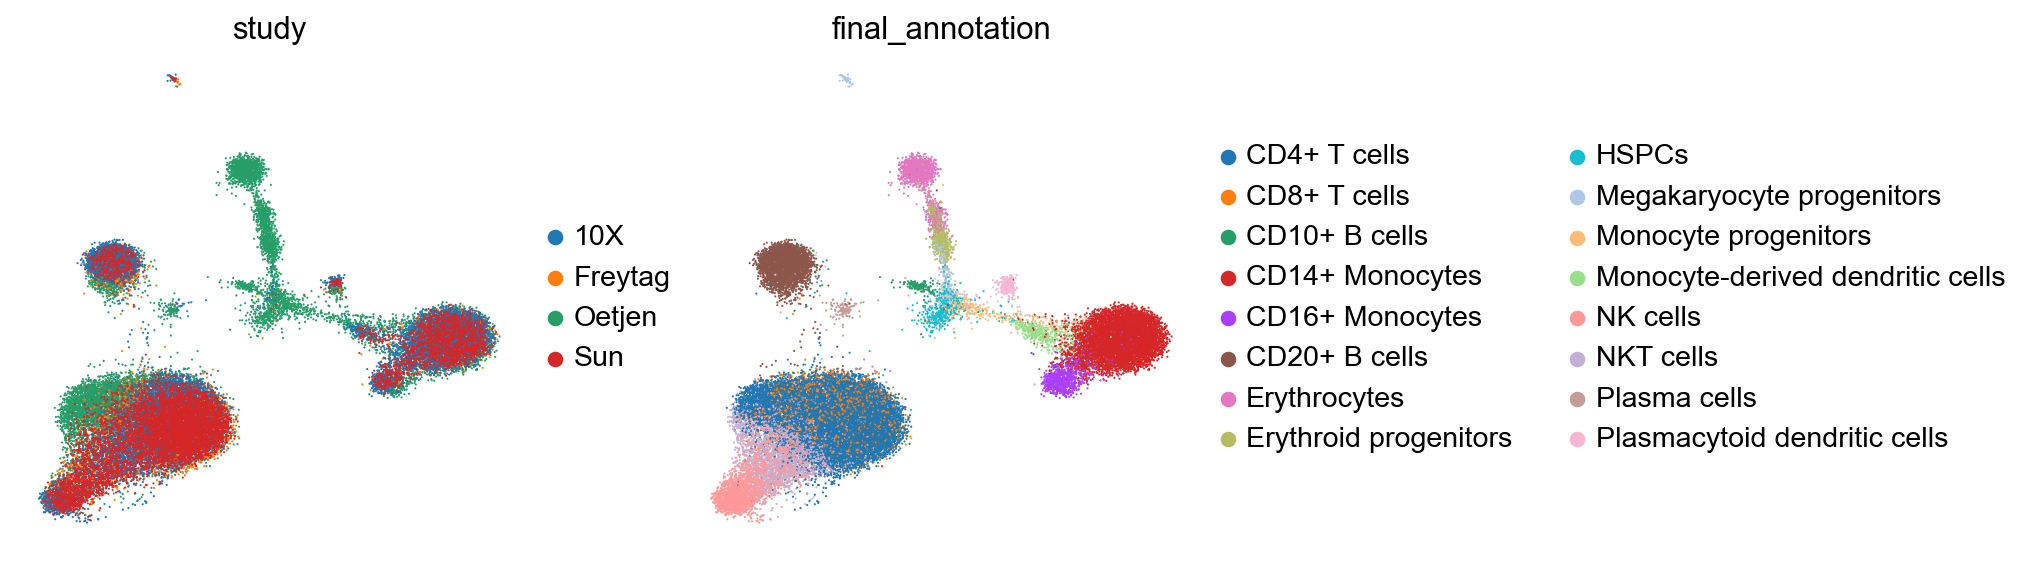

In [34]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [35]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')

In [36]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [37]:
kang.obs['study'] = 'Kang'

In [38]:
#q_intr_cvae = sca.models.TRVAE.load('q_intr_cvae_nb_alpha_kl_0_001_sd_2021', kang)

In [39]:
q_intr_cvae = sca.models.TRVAE.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1952 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 277
Decoder Architecture:
	Cond layer in, ext, ext_m, cond, out and :  277 0 0 5 1952
	with hard mask.


In [40]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |██████--------------| 30.5%  - epoch_loss:  526.57 - epoch_recon_loss:  520.61 - epoch_kl_loss:   59.61 - val_loss:  522.31 - val_recon_loss:  516.37 - val_kl_loss:   59.46
ADJUSTED LR
 |██████--------------| 34.5%  - epoch_loss:  524.02 - epoch_recon_loss:  518.06 - epoch_kl_loss:   59.60 - val_loss:  522.94 - val_recon_loss:  517.00 - val_kl_loss:   59.46
ADJUSTED LR
 |███████-------------| 37.5%  - epoch_loss:  523.92 - epoch_recon_loss:  517.99 - epoch_kl_loss:   59.30 - val_loss:  522.04 - val_recon_loss:  516.09 - val_kl_loss:   59.44
ADJUSTED LR
 |████████------------| 40.2%  - epoch_loss:  521.32 - epoch_recon_loss:  515.37 - epoch_kl_loss:   59.50 - val_loss:  522.15 - val_recon_loss:  516.20 - val_kl_loss:   59.47
ADJUSTED LR
 |████████------------| 42.0%  - epoch_loss:  519.50 - epoch_recon_loss:  513.57 - epoch_kl_loss:   59.24 - val_loss:  520.92 - val_recon_loss:  514.98 - val_kl_loss:   59.39
ADJUSTED LR
 |████████------------| 43.5%  - epoch_loss:  520.92 - epoch_reco

In [41]:
#q_intr_cvae.save('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020_rm5')

In [42]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [43]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [44]:
sc.tl.umap(kang)

... storing 'study' as categorical


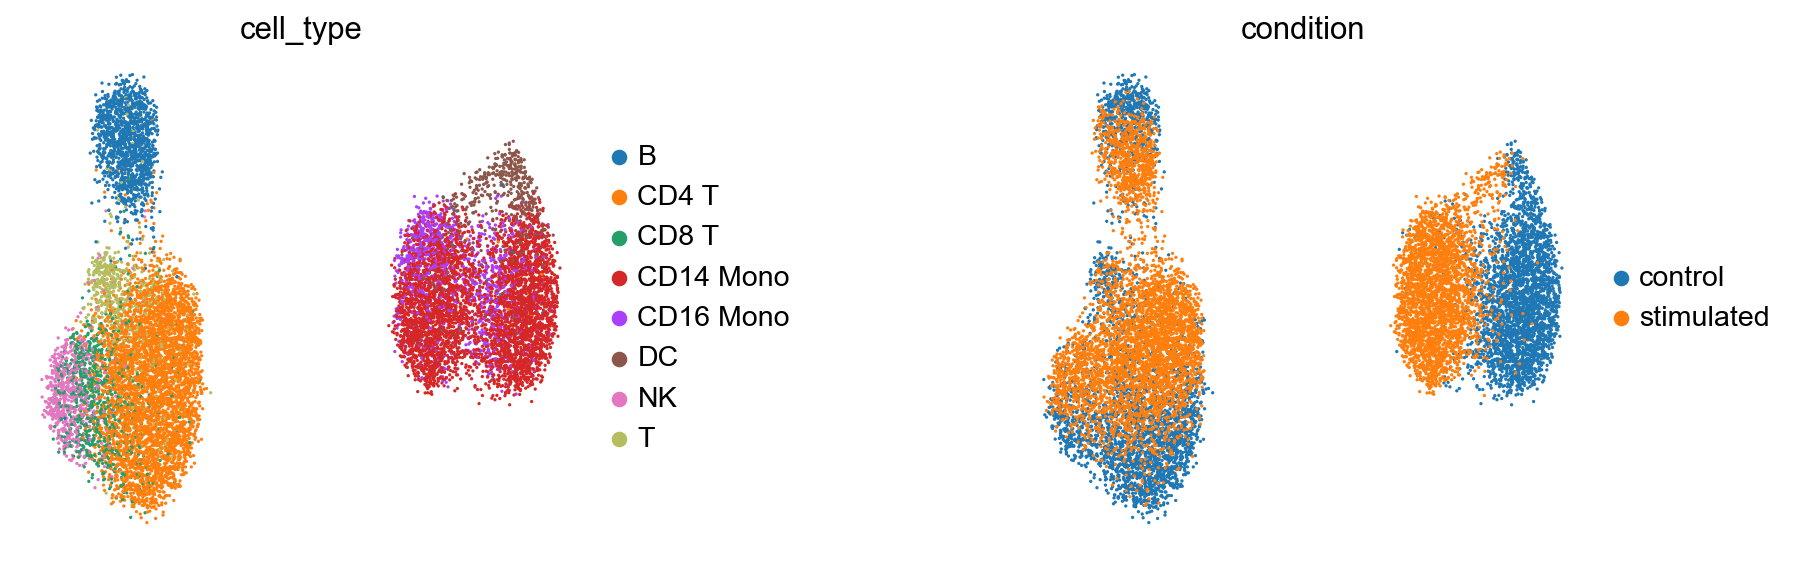

In [45]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

In [46]:
terms = adata.uns['terms']

In [47]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [48]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [49]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [50]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [51]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [52]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [53]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [54]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [55]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [56]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

... storing 'cell_type_joint' as categorical


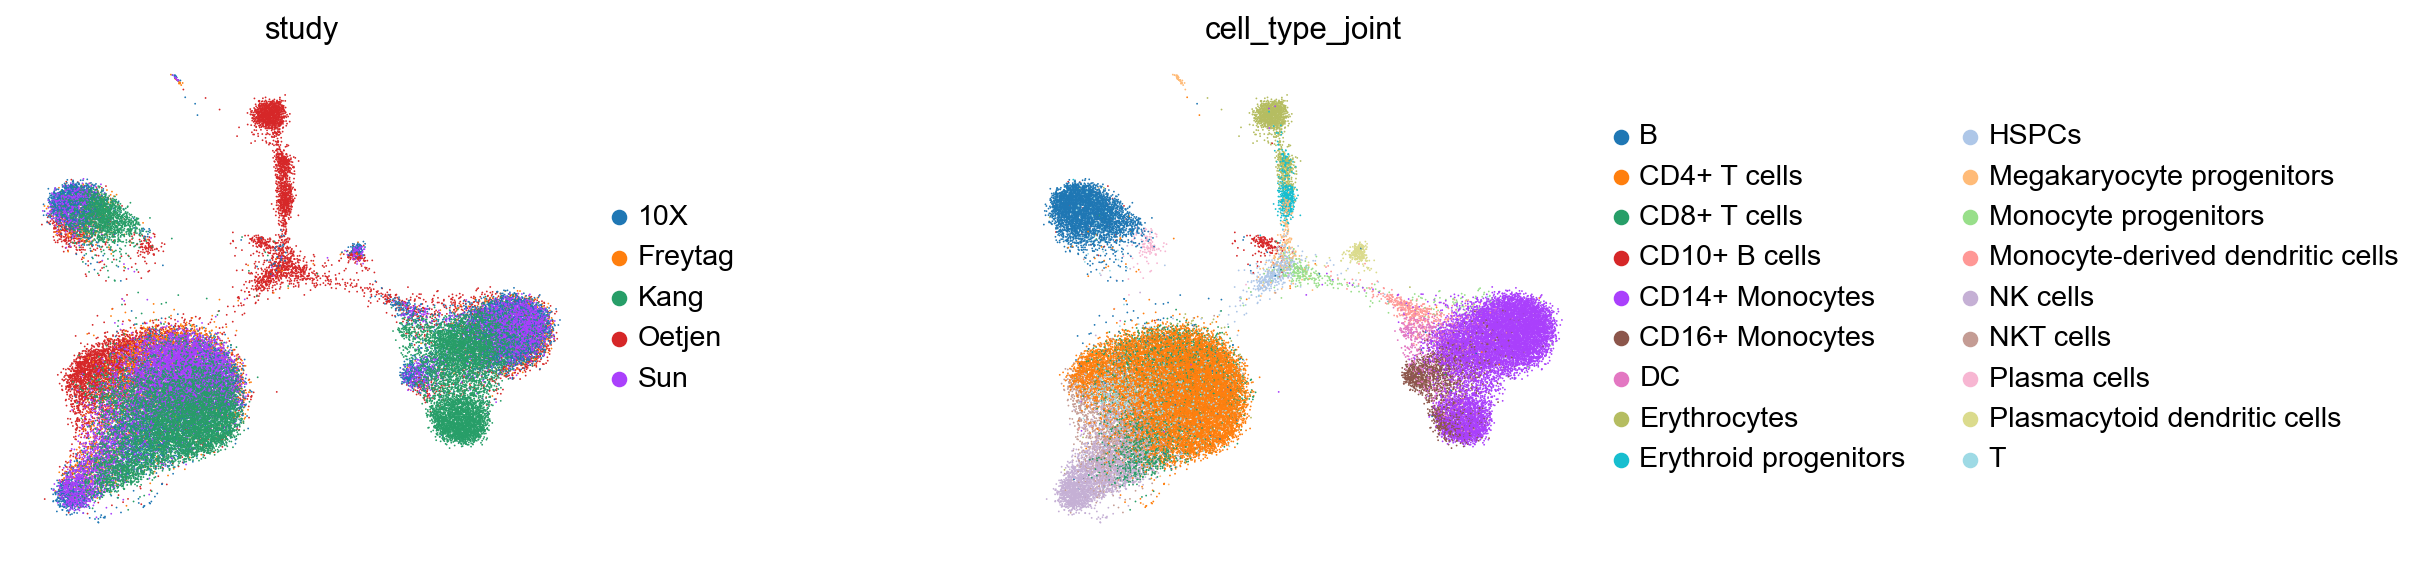

In [57]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

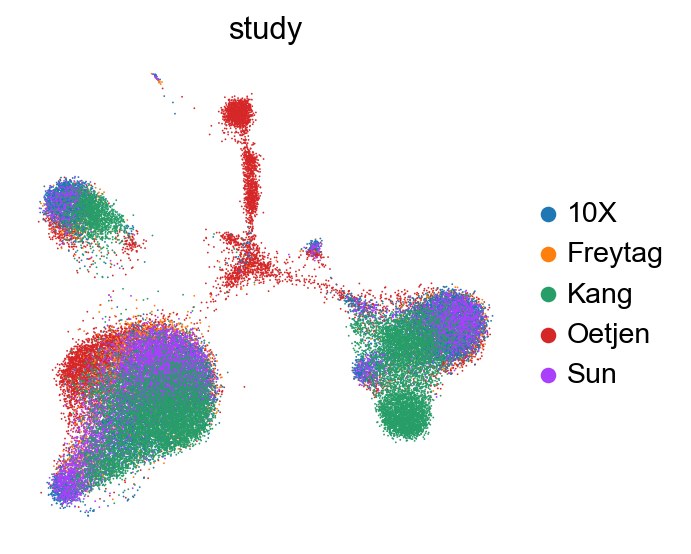

In [58]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

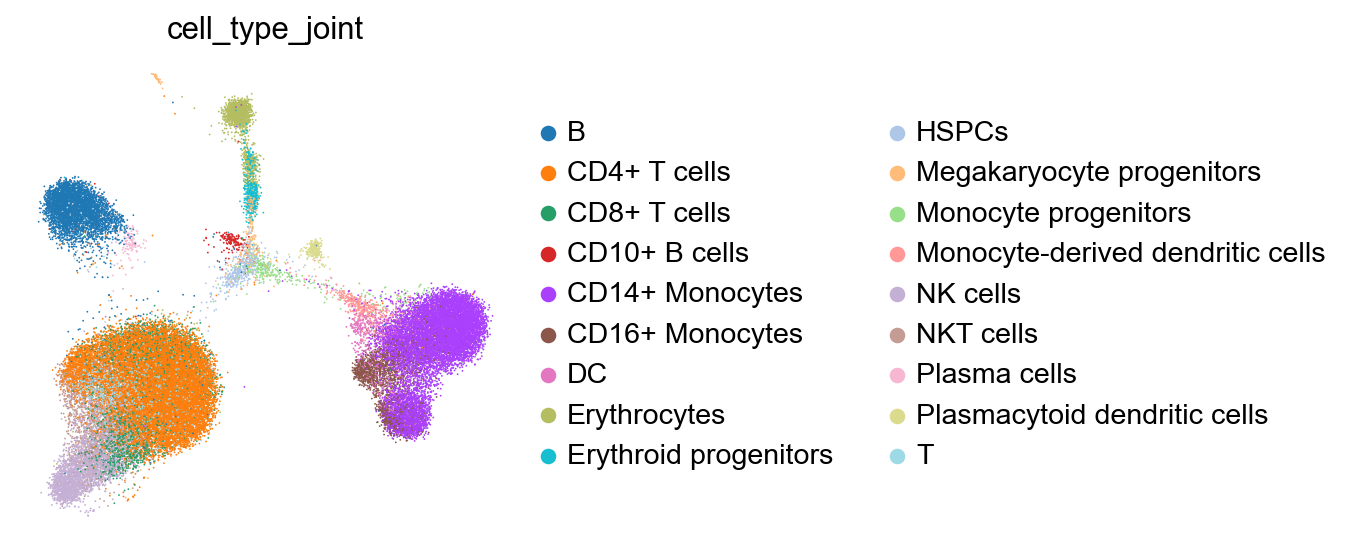

In [59]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

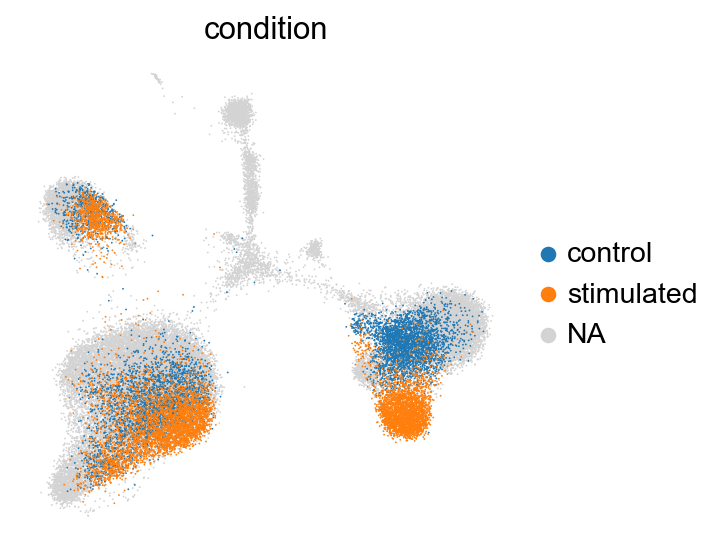

In [60]:
sc.pl.umap(kang_pbmc, color='condition', frameon=False, wspace=0.6)

In [61]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [62]:
kang_pbmc.write('kang_pbmc_integrated_rm5_immune.h5ad')